In [2]:
from fastai.vision.all import *
from fastai.vision.gan import * 

In [3]:
path_hr = Path('/kaggle/input/colorful-images/kaggle/working/new')
path_lr = Path('/kaggle/input/oldified-images/kaggle/working/old1')

In [86]:
# items = get_image_files(path_hr)
# bad_im = get_image_files(path_lr)
# im1 = PILImage.create(items[45])
# im2 = PILImage.create(bad_im[45])
# im1.show(); im2.show(figsize=(5,5))

In [4]:
def get_y_func(x):
    return path_hr/x.name

block = DataBlock(
    blocks=(ImageBlock, ImageBlock),
    get_items=get_image_files,
    get_y=get_y_func,
    splitter=EndSplitter(),
    item_tfms=[Resize(88, ResizeMethod.Crop)],
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)


In [5]:
dls_gen = block.dataloaders(path_lr , bs=16 , device=torch.device('cuda'))
dls_gen.c = 3

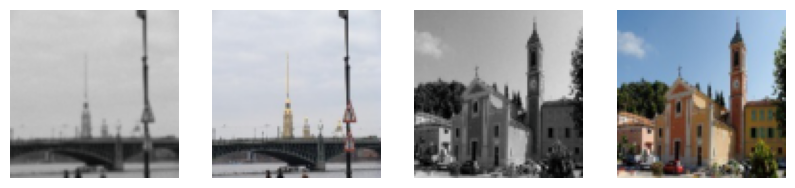

In [6]:
dls_gen.train.show_batch(max_n=2, figsize=(10,10))

In [7]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), L1LossFlat()

In [ ]:
import timm
timm.list_models()

In [8]:

def create_gen_learner():
    return unet_learner(dls_gen,  resnet34 , loss_func=loss_gen,
                        blur=True, norm_type=NormType.Spectral, self_attention=True,y_range=y_range)

In [9]:
learn_gen = create_gen_learner()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

# 88px

In [ ]:
learn_gen.fit_one_cycle(5, pct_start=0.8, wd=wd)

In [ ]:
learn_gen.unfreeze()

In [ ]:
import gc
gc.collect()


In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
learn_gen.fit_one_cycle(4, slice(3e-7,3e-4), wd=wd)


In [ ]:
learn_gen.show_results(max_n=4, figsize=(12,12))


# 128 px

In [ ]:
dls_gen = block.new(item_tfms = Resize(128 , ResizeMethod.Crop)).dataloaders(path_lr , bs = 12)
dls_gen.c=3
learn_gen.data = dls_gen

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(2, slice(3e-7,3e-4), wd=wd)

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(2, slice(3e-7,3e-4), wd=wd)

In [ ]:
learn_gen.show_results(max_n=4, figsize=(12,12))

# 192 px

In [10]:
dls_gen = block.new(item_tfms = Resize(192 , ResizeMethod.Pad , pad_mode='zeros')).dataloaders(path_lr , bs = 8)
dls_gen.c=3
learn_gen.data = dls_gen

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(4, slice(1e-7,1e-4), wd=wd)

In [ ]:
learn_gen.save('gen-res34')

In [11]:
learn_gen.load('/kaggle/input/deoldify-utils/gen-res34')

In [13]:
import gc 
gc.collect()

22955

In [14]:
path = Path('/kaggle/working/')
name_gen = 'image_gen'
path_gen = path/name_gen
path_gen.mkdir(exist_ok=True)
# device = 'cuda'
# default_device(use=True)

In [15]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [16]:
from torch.utils.checkpoint import checkpoint
from tqdm.auto import tqdm

def get_preds_with_checkpoint(dl, learn):
    preds = []
    for xb in tqdm(dl):
        with torch.no_grad():
            # use checkpoint to reduce memory usage
            pred = checkpoint(learn.model, xb[0])
            preds.append(pred)
    return preds

In [17]:
def save_preds(dl, preds):

    names = dl.dataset.items
    count = 0
    
    for i,pred in tqdm(enumerate(preds)):
        for j in range(len(pred)):            
            dec = dl.after_batch.decode((TensorImage(pred[j][None]).cpu(),))[0][0]
            arr = dec.numpy().transpose(1,2,0).astype(np.uint8)
            Image.fromarray(arr).save(path_gen/names[count].name)
            count=count+1

In [ ]:
dl = dls_gen.train.new(shuffle=False, drop_last=False, 
                       after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)],device=torch.device('cuda'))

In [ ]:
gc.collect()

In [ ]:
del dls_gen

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
import torch.nn as nn 
learn_gen.model = nn.DataParallel(learn_gen.model)

In [ ]:
preds = get_preds_with_checkpoint(dl , learn_gen)

In [ ]:
save_preds(dl, preds)

In [75]:
!zip -r gen.zip /kaggle/working/models

  adding: kaggle/working/models/ (stored 0%)
  adding: kaggle/working/models/gan-res34.pth (deflated 31%)
  adding: kaggle/working/models/critic-res34.pth (deflated 7%)


In [78]:
!zip -r images_generated.zip /kaggle/working/image_gen

  adding: kaggle/working/image_gen/ (stored 0%)
  adding: kaggle/working/image_gen/image8710.jpg (deflated 3%)
  adding: kaggle/working/image_gen/image24194.jpg (deflated 2%)
  adding: kaggle/working/image_gen/image3672.jpg (deflated 3%)
  adding: kaggle/working/image_gen/image20793.jpg (deflated 3%)
  adding: kaggle/working/image_gen/image28210.jpg (deflated 2%)
  adding: kaggle/working/image_gen/image17966.jpg (deflated 3%)
  adding: kaggle/working/image_gen/image31152.jpg (deflated 2%)
  adding: kaggle/working/image_gen/image33057.jpg (deflated 2%)
  adding: kaggle/working/image_gen/image31566.jpg (deflated 2%)
  adding: kaggle/working/image_gen/image17398.jpg (deflated 2%)
  adding: kaggle/working/image_gen/image23446.jpg (deflated 2%)
  adding: kaggle/working/image_gen/image17455.jpg (deflated 3%)
  adding: kaggle/working/image_gen/image8601.jpg (deflated 1%)
  adding: kaggle/working/image_gen/image24701.jpg (deflated 2%)
  adding: kaggle/working/image_gen/image6403.jpg (deflated 

In [18]:
path_gen = Path('/kaggle/input/deoldify-utils/images_generated/kaggle/working/image_gen')

In [19]:
path_g = get_image_files(path_gen)
path_i = get_image_files(path_hr)
fnames = path_g + path_i

In [20]:
def get_crit_dls(fnames, bs:int, size:int):
    splits = EndSplitter(0.1)(fnames)
    dsrc = Datasets(fnames, tfms=[[PILImage.create], [parent_label, Categorize]],
                 splits=splits)
    tfms = [ToTensor(), Resize(size , ResizeMethod.Crop)]
    gpu_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
    return dsrc.dataloaders(bs=bs, after_item=tfms, after_batch=gpu_tfms , device=torch.device('cuda'))

In [ ]:
del dl , learn_gen , preds
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()

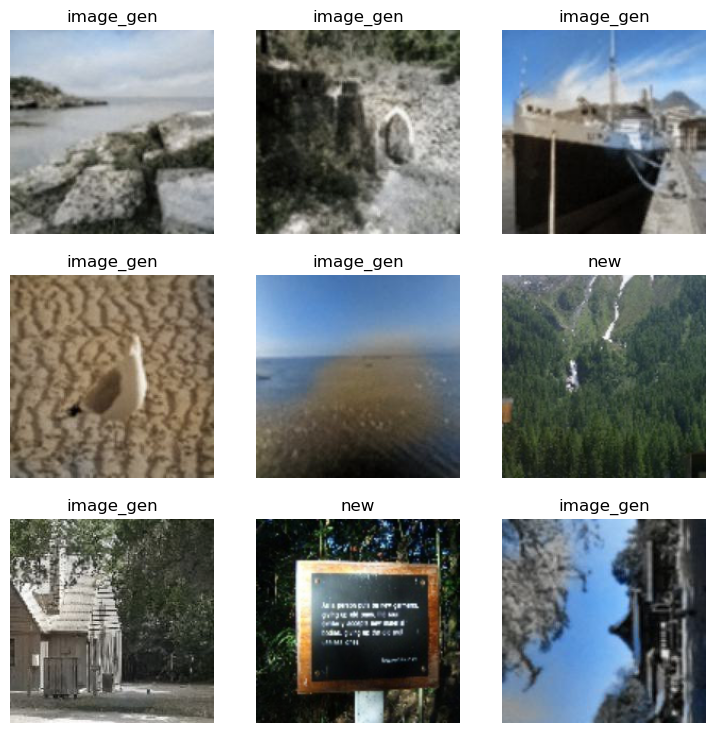

In [21]:
dls_crit = get_crit_dls(fnames, bs=16, size=192)
dls_crit.show_batch()
loss_crit = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [22]:
def create_crit_learner(dls, metrics):
    return Learner(dls, gan_critic(), metrics=metrics, loss_func=loss_crit)

In [ ]:
learn_crit = create_crit_learner(dls_crit, accuracy_thresh_expand)


In [ ]:
learn_crit.model = nn.DataParallel(learn_crit.model)

In [ ]:
gc.collect()

In [ ]:
learn_crit.fit_one_cycle(3, 1e-3, wd=wd)


In [ ]:
learn_crit.save('critic-vgg19')


In [23]:
dls_gen = block.new(item_tfms = Resize(192 , ResizeMethod.Pad , pad_mode='zeros')).dataloaders(path_lr , bs = 16)
dls_gen.c=3

In [25]:
learn_crit = create_crit_learner(dls_crit, metrics=None).load('/kaggle/input/deoldify-utils/gen (2)/kaggle/working/models/critic-res34')
learn_gen = create_gen_learner().load('/kaggle/input/deoldify-utils/gen-res34')

In [26]:
class GANDiscriminativeLR(Callback):
    def __init__(self, mult_lr=5.): self.mult_lr = mult_lr

    def begin_batch(self):
        if not self.learn.gan_trainer.gen_mode and self.training: 
            self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']*self.mult_lr)

    def after_batch(self):
        if not self.learn.gan_trainer.gen_mode: self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']/self.mult_lr)

In [27]:
switcher = AdaptiveGANSwitcher(critic_thresh=.65)

In [28]:
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.0), show_img=False, switcher=switcher,
                                 opt_func=partial(Adam, mom=0. , sqr_mom=0.9), cbs=GANDiscriminativeLR(mult_lr=5.))

In [29]:
learn_gen.data = dls_gen

In [30]:
lr = 2e-5

In [ ]:
learn.fit(10, lr, wd=wd)

In [ ]:
learn.save('gan-pre2')

In [32]:
learn.load('/kaggle/input/deoldify-utils/gen (2)/kaggle/working/models/gan-res34')

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:58: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


In [34]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def pad_and_resize(path):
    # Read the original image using plt.imread
    original_image = plt.imread(path)

    # Calculate the padding required to make the aspect ratio 1:1
    h, w, _ = original_image.shape
    padding = abs(h - w) // 2

    # Create a new image with the required padding
    if h > w:
        padded_image = np.ones((h, h, 3))*255
        padded_image[:, padding:w+padding, :] = original_image
    else:
        padded_image = np.ones((w, w, 3))*255
        padded_image[padding:h+padding, :, :] = original_image

    # Resize the padded image to 128x128
    resized_image = np.array(Image.fromarray(padded_image.astype(np.uint8)).resize((128, 128)))

    return resized_image



In [35]:
def deoldify(path) :
    img = plt.imread(path)
    res_img = pad_and_resize(path)
    pred = learn.predict(res_img)
    dec = dls_gen.after_batch.decode((TensorImage(pred[2][None]).cpu(),))[0][0]
    arr = dec.numpy().transpose(1,2,0)
    fig=plt.figure(figsize=(8, 8))
    fig.add_subplot(1,2,1)
    plt.imshow(res_img)
    fig.add_subplot(1,2,2)
    plt.imshow(arr)
    plt.show()

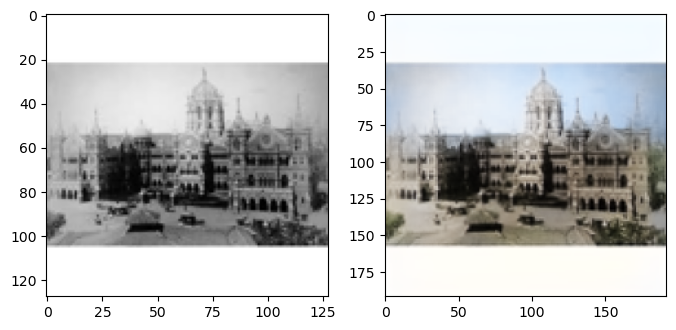

In [36]:
path = '/kaggle/input/oldies/images.jpg'
deoldify(path)

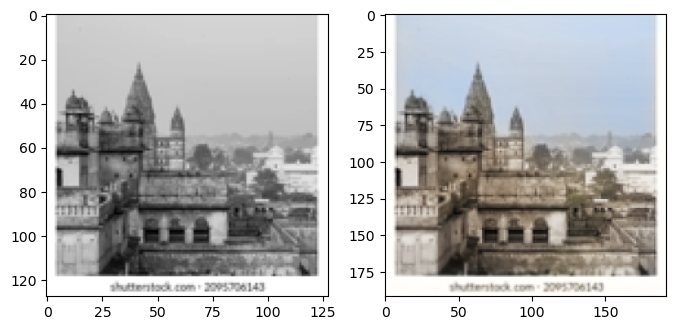

In [37]:
path = '/kaggle/input/oldies/jahangir-mahal-orchha-fort-madhya-260nw-2095706143.webp'
deoldify(path)

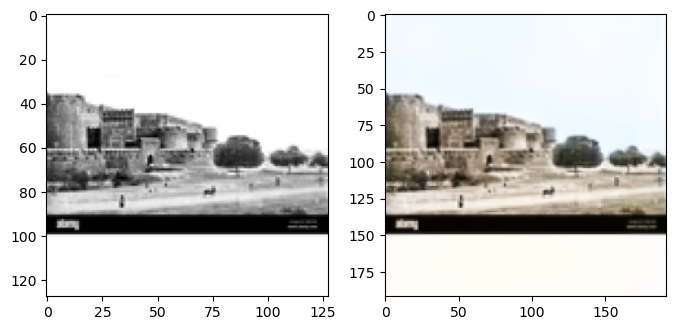

In [38]:
path = '/kaggle/input/testing-imagesold/fort-agra-february-1910-CW61RK.jpg'
deoldify(path)

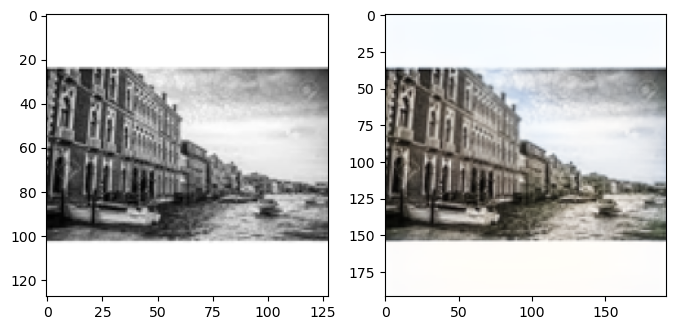

In [39]:
path = "/kaggle/input/testing-imagesold/images.jpg"
deoldify(path)